## Is it a comic?

Takes the Jupyter notebook from lesson 1 of the course and changes the task. Originally the lesson was to distinguish between images of a forest vs. a bird. With my (Tara's) edits, it distinguishes between Renaissance paintings and comics.

You will need to have the packages from the import statements installed for this code to run. If you are new to Python, you can read more here: https://packaging.python.org/en/latest/tutorials/installing-packages/

I highly recommend the course. You can find it at https://course.fast.ai/

In [14]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [15]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

## Step 1: Download images of comics and Renaissance paintings

In [16]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [17]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('comics', max_images=1)
urls[0]

'https://freshcomics.s3.amazonaws.com/issue_covers/DEC190702.jpg'

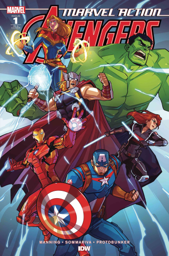

In [ ]:
# Look at the downloaded url for the comic
from fastdownload import download_url
dest = 'comic.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

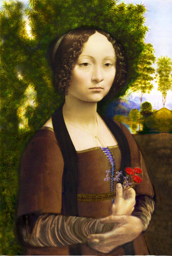

In [19]:
# Doing the same for Renaissance painting
download_url(search_images('renaissance paintings', max_images=1)[0], 'painting.jpg', show_progress=False)
Image.open('painting.jpg').to_thumb(256,256)

In [20]:
# Getting a few examples from each category
searches = 'renaissance painting','comic'
path = Path('comic_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

In [21]:
# Removing images that did not download correctly
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

18

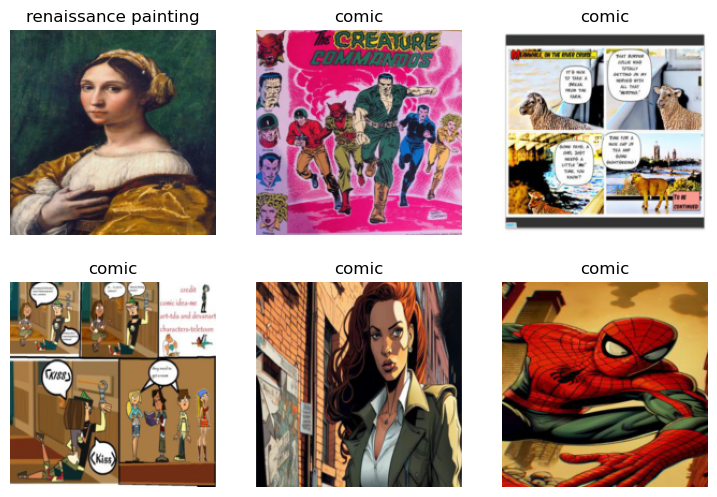

In [22]:
# Using DataLoaders to create training and validation sets
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

From the course:
>Here what each of the `DataBlock` parameters means:
>
>    blocks=(ImageBlock, CategoryBlock),
>
>The inputs to our model are images, and the outputs are categories (in this case, "comic" or "renaissance painting").
>
>    get_items=get_image_files, 
>
>To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).
>
>    splitter=RandomSplitter(valid_pct=0.2, seed=42),
>
>Split the data into training and validation sets randomly, using 20% of the data for the validation set.
>
>    get_y=parent_label,
>
>The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *comic* or *renaissance painting*).
>
>    item_tfms=[Resize(192, method='squish')]
>
>Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

In [23]:
# Training and fine tuning the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\tchia/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 15.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.638555,0.196747,0.055556,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.155845,0.119352,0.041667,00:19
1,0.107606,0.101637,0.027778,00:20
2,0.091089,0.071322,0.027778,00:21
3,0.068454,0.033008,0.013889,00:21
4,0.051123,0.025299,0.013889,00:20
5,0.040811,0.040140,0.013889,00:19
6,0.034572,0.048083,0.013889,00:20
7,0.027707,0.051063,0.013889,00:20


## Step 3: Use the model

In [24]:
# What is the model's prediction for the painting image we downloaded at the start?
is_comic,_,probs = learn.predict(PILImage.create('painting.jpg'))
print(f"This is a: {is_comic}.")
print(f"Probability it's a comic: {probs[0]:.4f}")

This is a: renaissance painting.
Probability it's a comic: 0.0000


The prediction was correct!